In [24]:
import os
print(os.getcwd())
# read files on drive
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/ece657/a4')

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# ==============================================================================
# ECE 657: Assignment 4 - Stroke Prediction
# STUDENT STARTER CODE
# ==============================================================================

# --- Import Essential Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Preprocessing & Pipeline ---
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# --- Machine Learning Models ---
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# --- Deep Learning Models ---
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import sys
print("Python:", sys.version)

import sklearn
print("Scikit-learn:", sklearn.__version__)

import pandas as pd
print("Pandas:", pd.__version__)

import xgboost as xgb
print("XGBoost:", xgb.__version__)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Scikit-learn: 1.6.1
Pandas: 2.2.2
XGBoost: 3.0.2


In [26]:

# --- Set up global parameters ---
# Set a random seed for reproducibility
RANDOM_STATE = 42
# Define the cross-validation strategy
# Using StratifiedKFold is good practice for imbalanced datasets
CV_SPLITS = 5
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# --- Set Plot Style ---
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
plt.rcParams['figure.figsize'] = [10, 6]

print("✅ Libraries imported and initial setup complete.")
print(f"Random State: {RANDOM_STATE}")
print(f"CV Folds: {CV_SPLITS}")

# ==============================================================================
# Part 0: Load Data
# ==============================================================================

# TODO: Load train.csv, test.csv, and sample_submission.csv here
# HINT: Use a try-except block to catch FileNotFoundError
try:
    train_df = pd.read_csv("/content/drive/MyDrive/ece657/a4/train.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/ece657/a4/test.csv")
    sample_submission_df = pd.read_csv("/content/drive/MyDrive/ece657/a4/sample_submission.csv")
    print("\nData loaded successfully!")
    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"\n❌ ERROR: {e}. Please ensure all CSV files are in the correct directory.")
    # Create empty dataframes to avoid further errors in the notebook
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

# Now you can begin with Part A...

✅ Libraries imported and initial setup complete.
Random State: 42
CV Folds: 5

Data loaded successfully!
Training data shape: (3576, 12)
Test data shape: (1533, 11)


In [27]:
print(train_df.head())
print(train_df.describe())

      id  gender   age  hypertension  heart_disease ever_married  \
0  45163  Female  47.0             0              0          Yes   
1  22330  Female  45.0             0              0          Yes   
2  43016    Male  10.0             0              0           No   
3  40980    Male  79.0             1              0          Yes   
4   1183    Male  39.0             0              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban              99.36  23.8           smokes   
1  Self-employed          Urban              82.94  29.3          Unknown   
2       children          Urban              70.70  25.4          Unknown   
3  Self-employed          Urban              72.04  23.6  formerly smoked   
4        Private          Rural              84.18   NaN           smokes   

   stroke  
0       0  
1       0  
2       0  
3       0  
4       0  
                 id          age  hypertension  heart_di

In [28]:
print(train_df.isnull().sum())
print()
print('----missing ratio----')
missing_ratio = train_df.isnull().mean() * 100
formatted = missing_ratio[missing_ratio > 0].apply(lambda x: f"{x:.2f}%")
print(formatted)
print()

print(train_df.dtypes)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  141
smoking_status         0
stroke                 0
dtype: int64

----missing ratio----
bmi    3.94%
dtype: object

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [29]:
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist() + ['hypertension','heart_disease']
print(categorical_features)
for cate_feat in categorical_features:
    print(train_df[cate_feat].value_counts())
    print()

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease']
gender
Female    2092
Male      1484
Name: count, dtype: int64

ever_married
Yes    2354
No     1222
Name: count, dtype: int64

work_type
Private          2026
Self-employed     589
children          496
Govt_job          450
Never_worked       15
Name: count, dtype: int64

Residence_type
Urban    1801
Rural    1775
Name: count, dtype: int64

smoking_status
never smoked       1330
Unknown            1083
formerly smoked     630
smokes              533
Name: count, dtype: int64

hypertension
0    3244
1     332
Name: count, dtype: int64

heart_disease
0    3375
1     201
Name: count, dtype: int64



stroke
0    3402
1     174
Name: count, dtype: int64
stroke
0    0.951342
1    0.048658
Name: proportion, dtype: float64


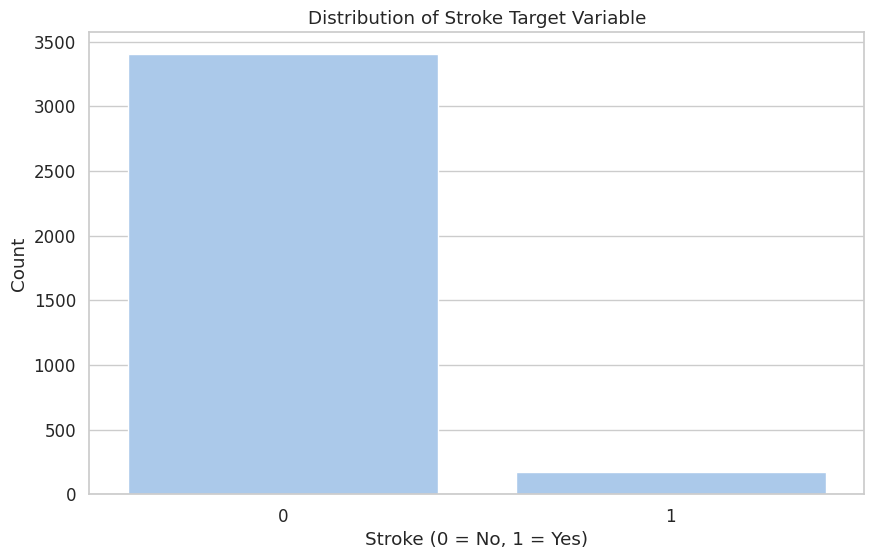

In [30]:
print(train_df['stroke'].value_counts())
print(train_df['stroke'].value_counts(normalize=True))
sns.countplot(x='stroke', data=train_df)
plt.title('Distribution of Stroke Target Variable')
plt.xlabel('Stroke (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

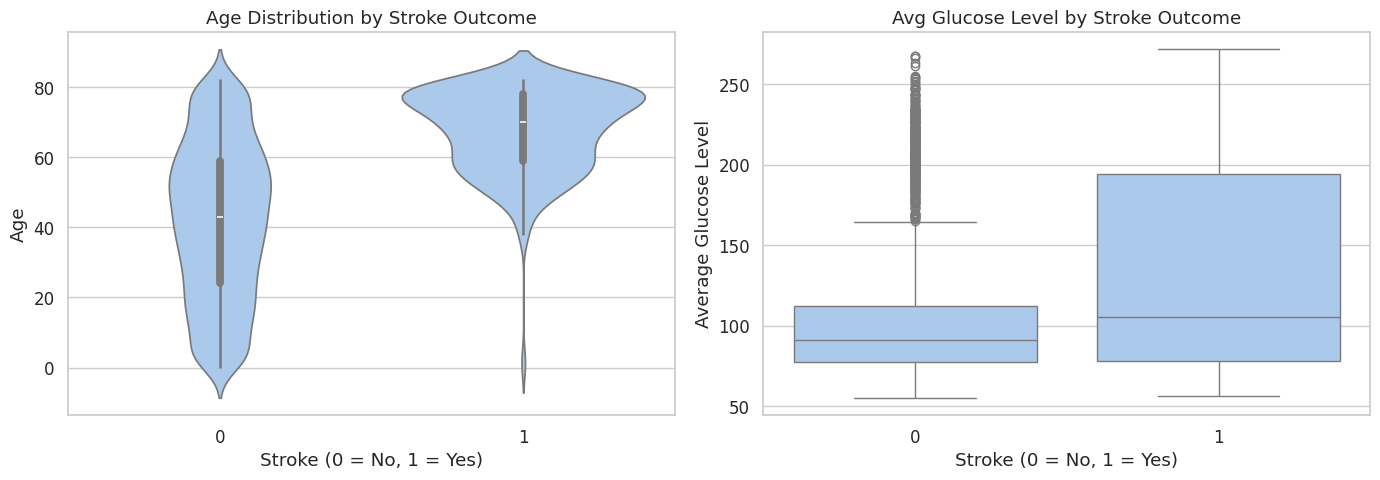

In [31]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.violinplot(ax=axes[0], data=train_df, x='stroke', y='age')
axes[0].set_title('Age Distribution by Stroke Outcome')
axes[0].set_xlabel('Stroke (0 = No, 1 = Yes)')
axes[0].set_ylabel('Age')

sns.boxplot(ax=axes[1], data=train_df, x='stroke', y='avg_glucose_level')
axes[1].set_title('Avg Glucose Level by Stroke Outcome')
axes[1].set_xlabel('Stroke (0 = No, 1 = Yes)')
axes[1].set_ylabel('Average Glucose Level')

plt.tight_layout()
plt.show()

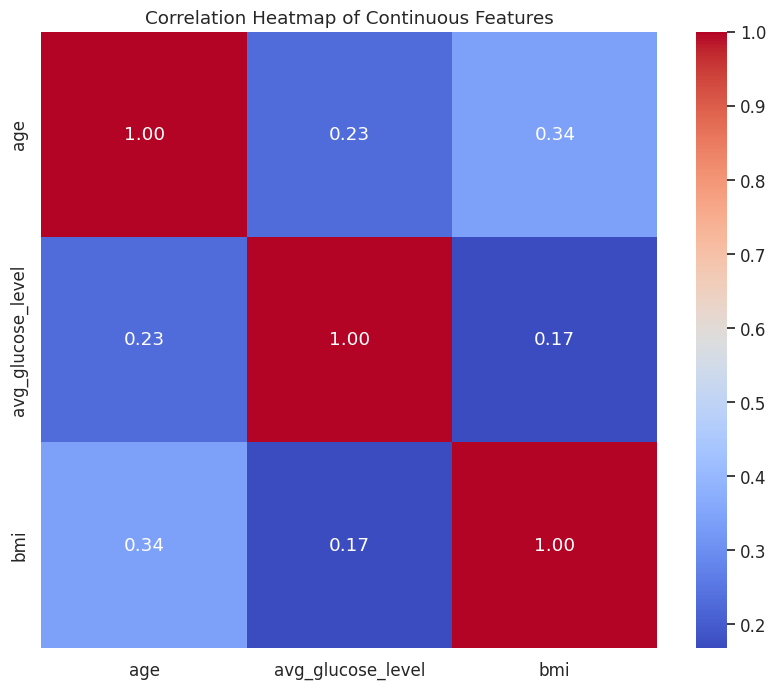

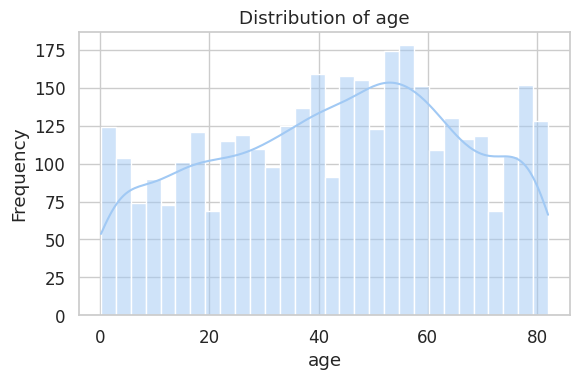

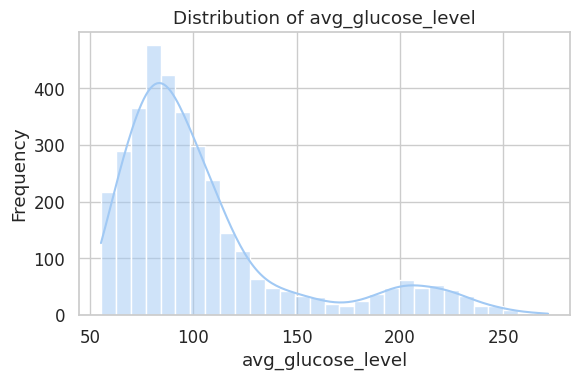

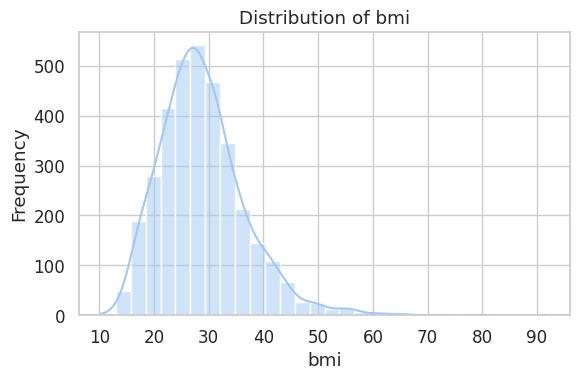

In [32]:
# relationships b\w Numerical features
numerical_cols = train_df.select_dtypes(include='number').columns.tolist()
continuous_features = [col for col in numerical_cols if col not in ['id', 'stroke','hypertension','heart_disease']]

corr = train_df[continuous_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Continuous Features")
plt.show()

# continuous_features distribution
for col in continuous_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [33]:
print(train_df['smoking_status'].value_counts())
print()
print(test_df['smoking_status'].value_counts())


smoking_status
never smoked       1330
Unknown            1083
formerly smoked     630
smokes              533
Name: count, dtype: int64

smoking_status
never smoked       562
Unknown            461
smokes             256
formerly smoked    254
Name: count, dtype: int64


In [34]:
# decision tree

X = train_df.drop(columns=['id', 'stroke'])
y = train_df['stroke']

excluded_features = [
    # 'smoking_status'
                    ]

numerical_cols = train_df.select_dtypes(include='number').columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

continuous_features = [col for col in numerical_cols if col not in ['id', 'stroke','hypertension','heart_disease'] + excluded_features]
categorical_features = [col for col in categorical_cols if col not in excluded_features] + ['hypertension','heart_disease']

continuous_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='most_frequent')),
    # ('onehot', OneHotEncoder(handle_unknown='ignore')) # don't use onehot
    ('cate', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('con', continuous_transformer, continuous_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # don't use other columns including id、stroke
)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

auc_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')

print("DT:")
print("AUC scores for 5 folds:", auc_scores)
print("Mean AUC:", auc_scores.mean())
print("Standard Deviation of AUC:", auc_scores.std())


DT:
AUC scores for 5 folds: [0.57650514 0.52872074 0.51418067 0.57132353 0.62153361]
Mean AUC: 0.5624527388047729
Standard Deviation of AUC: 0.03803879817054011


In [35]:
# KNN LR

X = train_df.drop(columns=['id', 'stroke'])
y = train_df['stroke']

excluded_features = [
    # 'smoking_status'
                    ]

numerical_cols = train_df.select_dtypes(include='number').columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

continuous_features = [col for col in numerical_cols if col not in ['id', 'stroke','hypertension','heart_disease'] + excluded_features]
categorical_features = [col for col in categorical_cols if col not in excluded_features] + ['hypertension','heart_disease']


# --- categorical features ---
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# --- no scaling ---
continuous_noscale = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor_noscale = ColumnTransformer([
    ('con', continuous_noscale, continuous_features),
    ('cat', categorical_transformer, categorical_features)
])

# --- scaling ---
continuous_scaled = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor_scaled = ColumnTransformer([
    ('con', continuous_scaled, continuous_features),
    ('cat', categorical_transformer, categorical_features)
])

# --- evalute model ---
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

def evaluate_model(model, preprocessor, name=''):
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)

    print(f"\n{name}")
    print(f"auc = {results['test_roc_auc'].mean():.4f} ± {results['test_roc_auc'].std():.4f}")
    for metric in scoring.keys():
        scores = results[f'test_{metric}']
        print(f"{metric.capitalize():<10}: {scores}")

# --- compare different models with or without scaling ---
print("== K-Nearest Neighbors ==")
evaluate_model(KNeighborsClassifier(n_neighbors=500), preprocessor_noscale, 'Without Scaling')
evaluate_model(KNeighborsClassifier(n_neighbors=500), preprocessor_scaled, 'With Scaling')

print("\n== Logistic Regression ==")
evaluate_model(LogisticRegression(max_iter=1000), preprocessor_noscale, 'Without Scaling')
evaluate_model(LogisticRegression(max_iter=1000), preprocessor_scaled, 'With Scaling')


== K-Nearest Neighbors ==


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p


Without Scaling
auc = 0.8244 ± 0.0243
Accuracy  : [0.95111732 0.95244755 0.95104895 0.95104895 0.95104895]
Precision : [0. 0. 0. 0. 0.]
Recall    : [0. 0. 0. 0. 0.]
F1        : [0. 0. 0. 0. 0.]
Roc_auc   : [0.8379484  0.81702945 0.85014706 0.78056723 0.83632353]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p


With Scaling
auc = 0.8242 ± 0.0277
Accuracy  : [0.95111732 0.95244755 0.95104895 0.95104895 0.95104895]
Precision : [0. 0. 0. 0. 0.]
Recall    : [0. 0. 0. 0. 0.]
F1        : [0. 0. 0. 0. 0.]
Roc_auc   : [0.81780994 0.83875356 0.83573529 0.77409664 0.85472689]

== Logistic Regression ==


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.p


Without Scaling
auc = 0.8354 ± 0.0237
Accuracy  : [0.95111732 0.95244755 0.94825175 0.95104895 0.95104895]
Precision : [0. 0. 0. 0. 0.]
Recall    : [0. 0. 0. 0. 0.]
F1        : [0. 0. 0. 0. 0.]
Roc_auc   : [0.85441578 0.84266218 0.83638655 0.78995798 0.85344538]

With Scaling
auc = 0.8352 ± 0.0238
Accuracy  : [0.95111732 0.95244755 0.94825175 0.95104895 0.95104895]
Precision : [0. 0. 0. 0. 0.]
Recall    : [0. 0. 0. 0. 0.]
F1        : [0. 0. 0. 0. 0.]
Roc_auc   : [0.85403818 0.84253261 0.83588235 0.78970588 0.85369748]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
# LR
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', LogisticRegression(max_iter=1000))
])


lr_pipeline.fit(X, y)
X_test = test_df.drop(columns=['id'])
y_pred_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]  # only get prob(y = 1)

In [37]:
# knn
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor_scaled),
    ('model', KNeighborsClassifier(n_neighbors=500))
])

knn_pipeline.fit(X, y)
X_test = test_df.drop(columns=['id'])
y_pred_proba_knn = knn_pipeline.predict_proba(X_test)[:, 1]  # only get prob(y = 1)

In [38]:
# xgboost
# === split different types of features ===
X = train_df.drop(columns=['id', 'stroke'])
y = train_df['stroke']

excluded_features = [
    # 'smoking_status'
                    ]

numerical_cols = train_df.select_dtypes(include='number').columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

continuous_features = [col for col in numerical_cols if col not in ['id', 'stroke','hypertension','heart_disease'] + excluded_features]
categorical_features = [col for col in categorical_cols if col not in excluded_features] + ['hypertension','heart_disease']

# === preprocessor ===
continuous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    # ('scaler', StandardScaler())  # can be changed to MinMaxScaler()
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cate', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', continuous_pipeline, continuous_features),
    ('cat', categorical_pipeline, categorical_features)
])

# === build XGBoost pipeline ===
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=4,
        eval_metric='logloss',
        random_state=42
    ))
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X, y, cv=cv, scoring='roc_auc')

print(f"XGBoost AUC: {scores.mean():.4f} ± {scores.std():.4f}")
print("XGBoost AUC on each fold:", scores)

XGBoost AUC: 0.8408 ± 0.0193
XGBoost AUC on each fold: [0.85580029 0.84095621 0.86334034 0.80737395 0.83651261]


In [39]:
# xgb trained all data for submission
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=4,
        eval_metric='logloss',
        random_state=42
    ))
])

xgb_model.fit(X, y)
X_test = test_df.drop(columns=['id'])
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  # only get prob(y = 1)


In [40]:
# lightgbm
# === split different types of features ===
X = train_df.drop(columns=['id', 'stroke'])
y = train_df['stroke']

excluded_features = []

numerical_cols = train_df.select_dtypes(include='number').columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

continuous_features = [col for col in numerical_cols if col not in ['id', 'stroke', 'hypertension', 'heart_disease'] + excluded_features]
categorical_features = [col for col in categorical_cols if col not in excluded_features] + ['hypertension', 'heart_disease']

# === preprocessor ===
continuous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cate', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ('num', continuous_pipeline, continuous_features),
    ('cat', categorical_pipeline, categorical_features)
])

# === LightGBM pipeline ===
lgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=4,
        random_state=42,
        verbose=-1
    ))
])

# === 5fold cross validation ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lgb_model, X, y, cv=cv, scoring='roc_auc')

print(f"✅ LightGBM AUC: {scores.mean():.4f} ± {scores.std():.4f}")
print("LightGBM AUC on each fold:", scores)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ LightGBM AUC: 0.8378 ± 0.0140
LightGBM AUC on each fold: [0.84631844 0.82866891 0.85968487 0.81968487 0.83441176]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [41]:
# lgb trained all data for submission
lgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=4,
        random_state=42,
        verbose=-1
    ))
])

lgb_model.fit(X, y)
X_test = test_df.drop(columns=['id'])
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]  # only get prob(y = 1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [42]:

# submit
probas = [
    y_pred_proba_knn.flatten(),
    y_pred_proba_lr.flatten(),
    # y_pred_proba_xgb.flatten(),
    # y_pred_proba_lgb.flatten(),
]


y_pred_proba_ensemble = np.mean(probas, axis=0)

# === generate submission file ===
submission = pd.DataFrame({
    'id': test_df['id'],
    'stroke': y_pred_proba_ensemble
})
submission.to_csv('submission.csv', index=False)
print("✅ Saved 'submission.csv' with predicted probabilities.")

# === save to local computer ===
from google.colab import files
files.download('submission.csv')


✅ Saved 'submission.csv' with predicted probabilities.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Final Report
I experimented with logistic regression, KNN, decision trees, XGBoost, LightGBM. I designed preprocessing pipelines using ColumnTransformer and Pipeline, handled missing values, and used different encoding strategies to properly represent categorical features: in tree model, I use categorical encoding; in logistic regression and KNN, I use one-hot encoding.

Among all models, decision tree has lowest auc in 5-fold cv and thus I did not submit it in kaggle; logistic regression, knn and xgboost got 0.85400, 0.84825 and 0.84503 respectively in kaggle. I used ensemble techniques to further improve predictions and **averaging of logistic regression and knn outputs performed best (0.86026)** on the leaderboard.

### Other related work (but fail to get higher scores):

(1) fill 'unknown' in the smoking_status feature with random forest

(2) find better model hyperparameters in LR and KNN with GridSearchCV

(3) different DNN models

